# DSCI471 Exploratory Data Analysis
Harry Zhao, Yi Pan, Yantian Ding

In [47]:
import pandas as pd
from math import ceil
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
from pylab import rcParams 
import statsmodels.api as sm 
from pandas import Series
import os
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

## Loading Data

In [2]:
#file location
file_dir='./speed_data'

We have separated all data into 31 csv files depending on each day it was in Preprocessing. Now we combine all these files together as a single dataframe


In [3]:
#Read all csv files 
all_csv_list = os.listdir(file_dir)
for single_csv in all_csv_list:
    single_data_frame = pd.read_csv(os.path.join(file_dir, single_csv),index_col=0)
    if single_csv == all_csv_list[0]:
        all_data_frame = single_data_frame
    else:  # concatenate all csv to a single dataframe, ingore index
        all_data_frame = pd.concat([all_data_frame, single_data_frame], ignore_index=True)

In [4]:
#data display
all_data_frame

,day,hour,road_id,speed_mph_mean,spped_mph_stddev
0,1,0,24785,23.231,7.068
1,1,0,17767,27.017,4.603
2,1,0,42750,26.704,4.395
3,1,0,16443,21.793,8.823
4,1,0,50404,25.798,6.274
...,...,...,...,...,...
16328563,9,23,57508,40.000,0.000
16328564,9,23,57507,40.000,0.000
16328565,9,23,97521,40.000,0.000
16328566,9,23,87539,52.645,5.473


In [7]:
#change type of road id to list
road=all_data_frame.road_id
roadid=list(road.values)
set_a=set(roadid)
list_a=list(set_a)
#extract keys
keys=[]
for i in range(len(list_a)):
    keys.append(int(list_a[i]))

In [8]:
#for our project, we consider each road as a unique node. Here we extract mean speed of 31 days for each road and store it in dict road_dict
road_dict={}
for i in tqdm(list_a):
    road_dict[i]=all_data_frame[all_data_frame.road_id == i].speed_mph_mean.mean()
road_dict.values

100%|████████████████████████████████████████████████████████████████████████████| 21947/21947 [05:25<00:00, 67.46it/s]


<function dict.values>

In [9]:
#Here we extract mean speed of each day for all roads and store it in dict day_speed_dict
day_speed_dict={}
for i in tqdm(range(1,32)):
    day_speed_dict[i]=all_data_frame[all_data_frame.day==i].speed_mph_mean.mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.24it/s]


In [10]:
day_dict={}
#Count the amount of valid data for all road sections during each day, which is that the average speed is not the fill value 40.
def day_car_number(shape):
    for i in range(1,32):
        count=0
        for j in range(shape[0]):
            if all_data_frame.day[j]==i and all_data_frame.speed_mph_mean[j]!=40:
                count+=1
            else:
                continue
        day_dict[i]=count
    return day_dict

In [11]:
#use function with combined dataframe's dimension
car_number_dict=day_car_number(all_data_frame.shape)

In [27]:
#change our data to a standard to help us process it.
car_number=pd.DataFrame(list(car_number_dict.items()))
car_number=car_number.drop([0],axis=1)
car_number=car_number.rename(columns={1:'number'})
car_number

,number
0,452171
1,411702
2,423264
3,443543
4,442696
5,416707
6,409662
7,417649
8,425664
9,436133


In [29]:
#change our data to a standard to help us process it.
day_speed=pd.DataFrame(list(day_speed_dict.items()))
day_speed=day_speed.drop([0],axis=1)
day_speed=day_speed.rename(columns={1:'speed'})
day_speed

,speed
0,26.223861
1,26.585120
2,25.575423
3,25.531675
4,26.333358
5,25.911035
6,26.101441
7,25.708946
8,25.188359
9,24.685863


In [32]:
#Here we combine two dataframe together to find pair relationship.
result = pd.concat([car_number, day_speed], axis=1)
result

,number,speed
0,452171,26.223861
1,411702,26.585120
2,423264,25.575423
3,443543,25.531675
4,442696,26.333358
5,416707,25.911035
6,409662,26.101441
7,417649,25.708946
8,425664,25.188359
9,436133,24.685863


In [33]:
#We read data for each hour of a day, there is a mean speed value corresponding to it for all roads. 
new_speed=pd.read_csv('day_hour_mean.csv')
new_speed

,day,hour,mean
0,1,0,23.562019
1,1,1,22.732024
2,1,2,23.383710
3,1,3,24.201996
4,1,4,25.084813
...,...,...,...
739,31,19,22.103625
740,31,20,21.654565
741,31,21,21.546851
742,31,22,22.421463


## Time series decomposition

### Hourly Average Speed

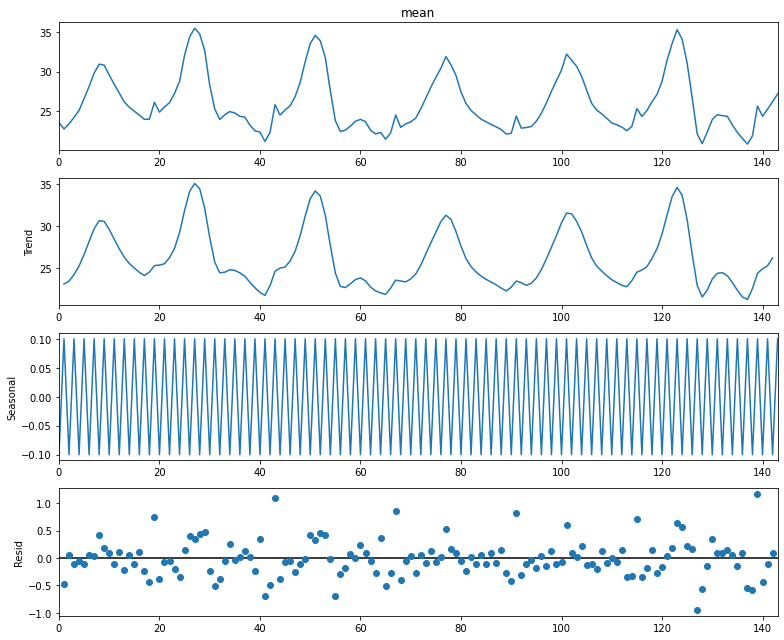

In [34]:
# Show decomposition of hour speed, here we use the first 144 hour data
rcParams['figure.figsize'] = 11, 9 
decomposition = sm.tsa.seasonal_decompose(new_speed['mean'][:144], model='Additive',period=2) 
fig = decomposition.plot() 
plt.show()

Here we plot four graphs to analyze the time series relationship for each hour.

The first graph is a line graph of the actual observed hourly average velocity. We use the line graph to reflect the trend of the data. Here is a smooth variation trend.

The second graph is the overall trend change data. From the graph we can see that the trend of the average speed data is smooth and does not show a significant increase or decrease.

The third graph shows the seasonal data exhibited by the whole series. By looking at the images, we find that the average velocity data varies periodically with a steady frequency. Therefore, we consider our time series data to be seasonal.

The fourth plot is a plot of the residual data. The residuals represent the random variation in the time series, and this is the part we need to focus on predicting. By looking at these images, we find that the residual values of the average velocity data are regularly distributed on both sides of 0, which is a normal situation.


### Daily Average Speed

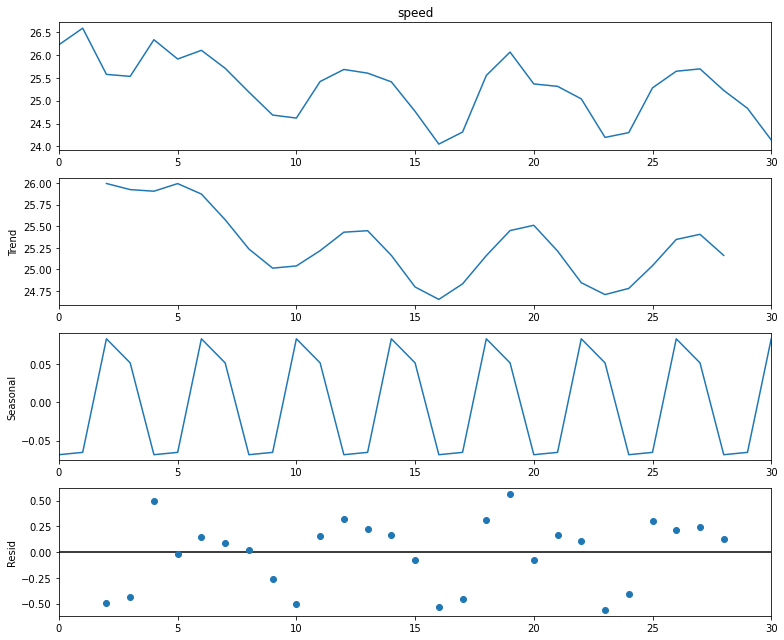

In [35]:
# draw decomposition graph based on daily speed
rcParams['figure.figsize'] = 11, 9 
decomposition = sm.tsa.seasonal_decompose(day_speed['speed'], model='Additive',period=4) 
fig = decomposition.plot() 
plt.show()

In the aforementioned step we have counted the average speed data of all road sections per day.

Here we also plot four graphs to analyze the daily time series data.

The first graph is a line graph of the actual observed average speed. We use the line graph to reflect the trend of the data. 
You can see that there is a downward trend here.

The second graph is the overall trend change data. From the graph, we can find that the trend of the average velocity data is 
smooth and shows a gradually decreasing trend.

The third graph shows the seasonal data exhibited by the whole series. By looking at the images, we find that the average velocity data varies periodically at a steady frequency. Therefore we consider our time series data to be seasonal in nature.

The fourth graph is the residual data graph. The residuals represent the random variation in the time series, which is the part we need to focus on predicting. By looking at the images, we find that the residual values of the average velocity data are regularly distributed on both sides of 0, which is a normal situation.


### Daily Average Car Number (Volumn) 

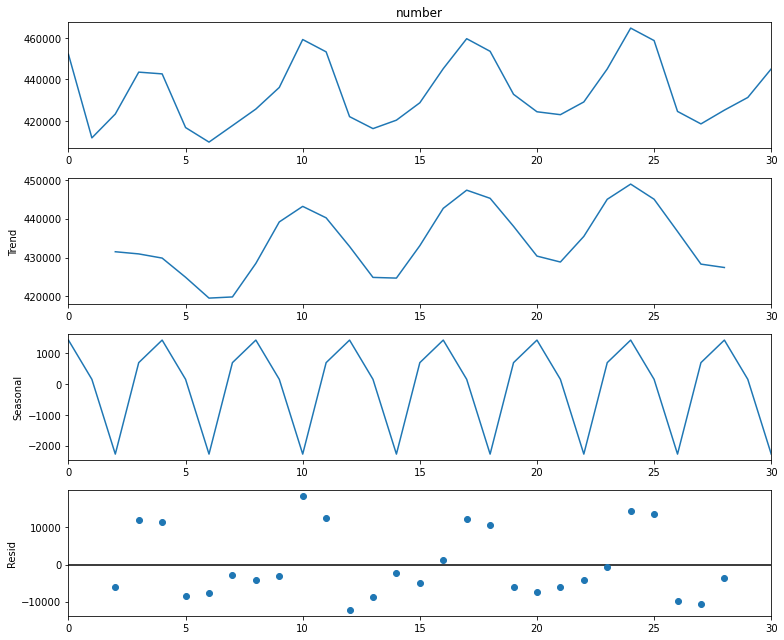

In [36]:
# draw decomposition graph based on car_number
rcParams['figure.figsize'] = 11, 9 
decomposition = sm.tsa.seasonal_decompose(car_number['number'], model='Additive',period=4) 
fig = decomposition.plot() 
plt.show()

In the aforementioned step we have counted the daily traffic data of all road sections.

Here we plot four graphs to analyze the daily car number(volumn) data.

The first graph is a line graph of the actual values we observed. We use the line graph to reflect the trend of the data. We can find there is a upward trend. 

The second graph is the overall trend change data. From the graph, we can find that the trend of the traffic data is smooth and shows a positive trend of change.

The third graph shows the seasonal data exhibited by the whole series. By looking at the images, we find that our data vary periodically with a steady frequency. Therefore we consider our time series data to be seasonal in nature.

The fourth graph is the residual data graph. The residuals represent the random variation in the time series, which is the part we need to focus on predicting. By looking at the images, we find that the residual values of the data are regularly distributed on both sides of 0, which is a normal situation.

## Traffic Flow versus Speed

### Pair Plot

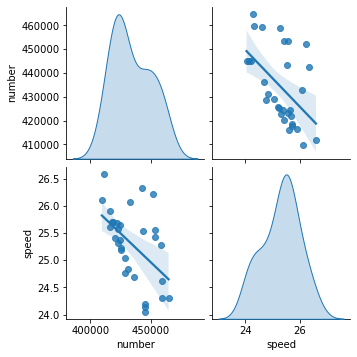

In [41]:
# Show pair plot to find linear relationship
sns.pairplot(result,kind="reg",diag_kind="kde")

We use pair plot to show the relationship between two variables. In the above graph we can see that over time, the traffic flow data shows an increasing trend while the average daily speed data shows a decreasing trend.

Therefore, we analyze the relationship between the two data here. As shown in the following scatter plot, when we compare the two data together, we can find that they have a significant negative linear correlation. 

That is, when the traffic number increases, the average speed decreases, and vice versa.

## Stationarity Test

### ADF TEST

In [51]:
#Calculate ADF value and p value based on hour speed
speed_result = adfuller(new_speed['mean'])

print('The ADF Statistic of speed: %f' % speed_result[0])
print('The p value of speed: %f' % speed_result[1])

The ADF Statistic of speed: -3.473677
The p value of speed: 0.008689


Here we use ADF test to check if the series is stable or not.

The assumption is that there is a unit root, which means the series is unstable. We need to calculate p value here to check if we can reject the original assumption. 

Our confidence level is 0.05 and the calculated p value is less than 0.05, which means we can reject original assumption, in this case our series is stable without unit root. This also guarantee that we can go to ACF TEST and PACF TEST. 

## Autocorrelation Test

### Autocorrelation

<Figure size 720x288 with 0 Axes>

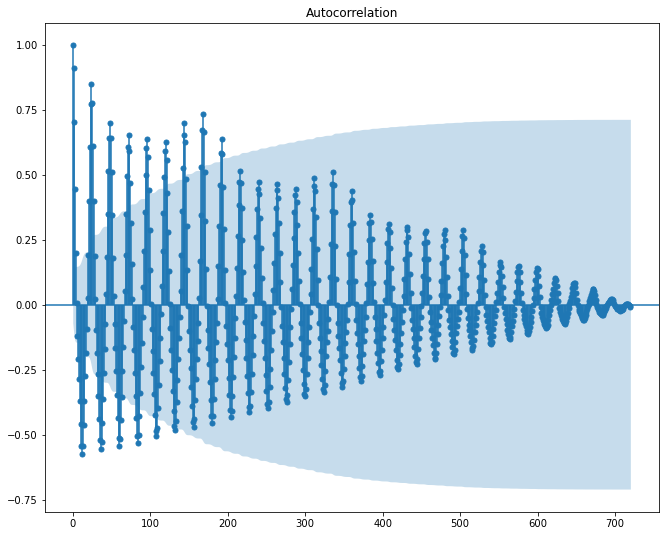

In [45]:
#Here we show acf autocorrelation based on hour speed
plt.figure(figsize=(10,4))
acf_plot = plot_acf(new_speed['mean'], lags=720)

Here we use ACF test the stability of time series. 

For a stable time series, autocorrelation implies that it is possible to predict the future with historical data. The blue area is the margin of error. Data in the region are considered insignificant. The pattern of progressively decreasing ACF amplitude generally implies the existence of autocorrelation, because we can see ACF is stable and are gradually approaching 0, we can get to PACF part. 

### Partial Autocorrelation

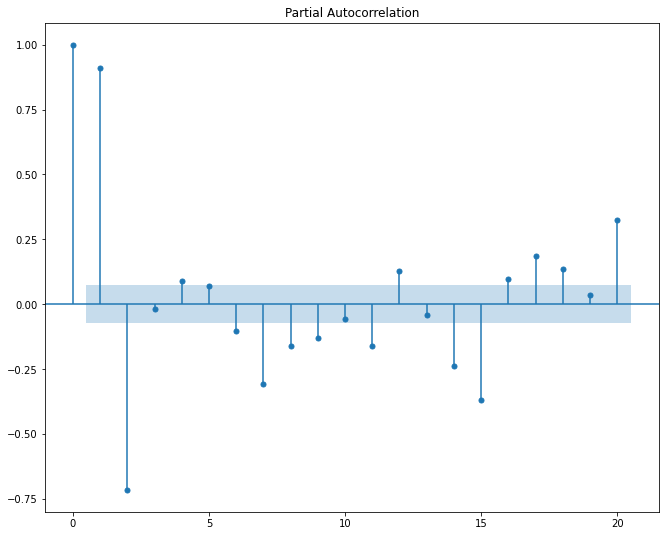

In [54]:
#Here we show pacf graph of hour speed
pacf_plot = plot_pacf(new_speed['mean'],lags=20)

In PCAF we can find on which cycles are autocorrelation.

PACF considers only cycle-specific correlations, which gives us a good starting point for determining the autocorrelation cycle. In ACF graph, we can see that the ACF is a dragging tail that gradually tends to 0. In PACF when lag is 3, it is very close to 0 so we can consider use model like ARMA(3,0) to form a time series model. 

### Lagging Test

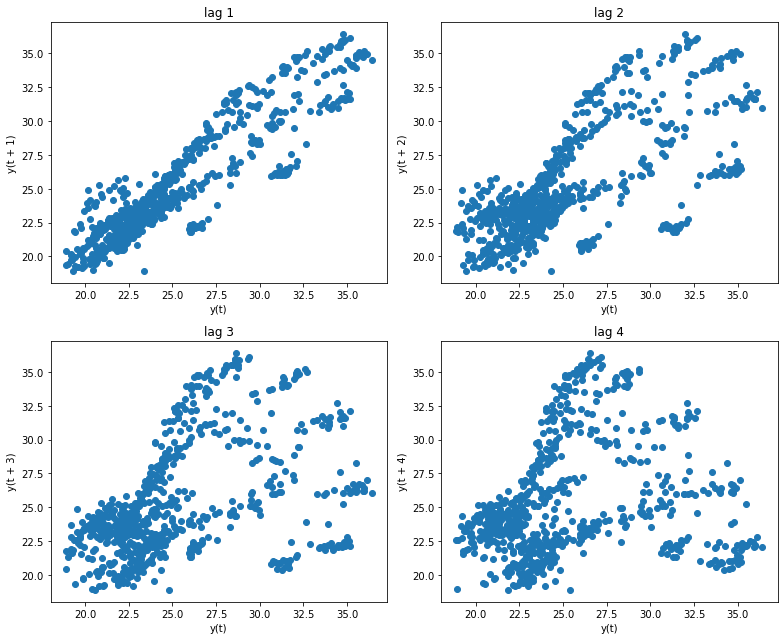

In [49]:
#Lag plot with 4 subplots, lag range is from 1 to 4
plt.subplot(2, 2, 1)
pd.plotting.lag_plot(new_speed['mean'],lag=1)
plt.title("lag 1")

plt.subplot(2, 2, 2)
pd.plotting.lag_plot(new_speed['mean'],lag=2)

plt.title("lag 2")

plt.subplot(2, 2, 3)
pd.plotting.lag_plot(new_speed['mean'],lag=3)

plt.title("lag 3")

plt.subplot(2, 2, 4)
pd.plotting.lag_plot(new_speed['mean'],lag=4)
plt.title("lag 4")

plt.tight_layout()
plt.show()

In the lag diagrams we can see that as the lag gets larger, the higher the divergence of the points, and a clear linear relationship can be found when the lag is 1. Therefore for this data we should choose the first order lag diagram.

# Conclusion

For our explory data analysis in time series, we have explored and analyzed various aspects and obtained some results. There are three major starting bases for our time series exploration: daily traffic flow data for all roads, daily average speed data for all roads, and hourly average speed data for each road.

First, we decompose these three kinds of data to draw the actual data graph, trend graph, season graph, and resid graph. All three data show their unique regular variations in these four drawn graphs. In particular, we find that there exist opposite changes in trend graphs for the daily traffic flow data and the daily average speed data. Therefore, we used a pair plot to observe the relationship between them. We plotted both data on the same scatter plot and found that the daily traffic flow data and the average speed data showed a clear negative linear relationship. This has significant implications for our future feature extraction, and we can consider traffic flow data as features in our modeling.

Since we have found linear relationships between the daily data and still no significant progress for the hourly data. We are ready to start with the hourly data for a deeper analysis. We begin with stability analysis and autoregressive plotting using ACF and adf methods. In the ADF TEST, we assume the existence of a unit root in the series, which means the series is unstable. The rejection of the original hypothesis is determined by calculating the p-value of the data at the 0.05 confidence level. The p-value we figured is less than 0.05, so we reject the original hypothesis, which means the sequence is stable and has no unit root, which means no differential transformation is needed. A regular series means that we can perform autocorrelation and partial autocorrelation analysis. We use ACF and PACF for correlation tests. The autocorrelation decreases as the lag increases and shows a fetch that converges to zero in the ACF plot. In the PACF plot, we find that the value of partial autocorrelation is basically 0 when the lag is 4. Therefore, we can consider using ARMA(3,0) models in future modeling of time series. After that, we plotted the lag graph. We can see that as the lag increases, the linear correlation shown in the plot gradually decreases, while when the lag is 1, an undeniable linear correlation is presented. This is in line with the trend of autocorrelation in ADF plots.

So in the time series part of EDA, we have found some obvious feature which can be applied in our project and some portable time-series models we can use in our modeling part in the future. 